In [1]:
import sys
import os

# Add the directory containing instruments.py to the Python path
custom_module_path = "/home/rebeccaz/Github/vampires_calibration"
sys.path.append(custom_module_path)

import instruments as inst
import numpy as np
import json

# Step 1: Setting up initial information

In [2]:
# Data path for processed csv
file_path = custom_module_path + "/20230914_processed_table.csv"
wavelengths = ["775-50"]
obs_modes = ["IPOL"]
save_fits_directory = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/"
previous_fits_directory = save_fits_directory
em_gains = [1.190700]

# Step 2: Performing fits iteratively by wavelength - first broadband then MBI

{'dichroic': {'phi': 1.3764243819248705, 'epsilon': 0.002704207405255751, 'theta': 7.254640119333228}, 'flc': {'phi': 2.632458460684317, 'delta_theta': 4.395796688939583}, 'optics': {'phi': 0.6411787275576513, 'epsilon': 1.1176067851459513e-07, 'theta': -17.116911324181473}, 'image_rotator': {'phi': 3.165689224407034}, 'hwp': {'phi': 2.8950593774410223, 'delta_theta': 4.965787403276952}, 'lp': {'theta': 1.1294517466411973}}
[[0.49271441 0.49233153 0.01942038 0.        ]
 [0.49271441 0.49233153 0.01942038 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]
logl value: 358.3425726897194


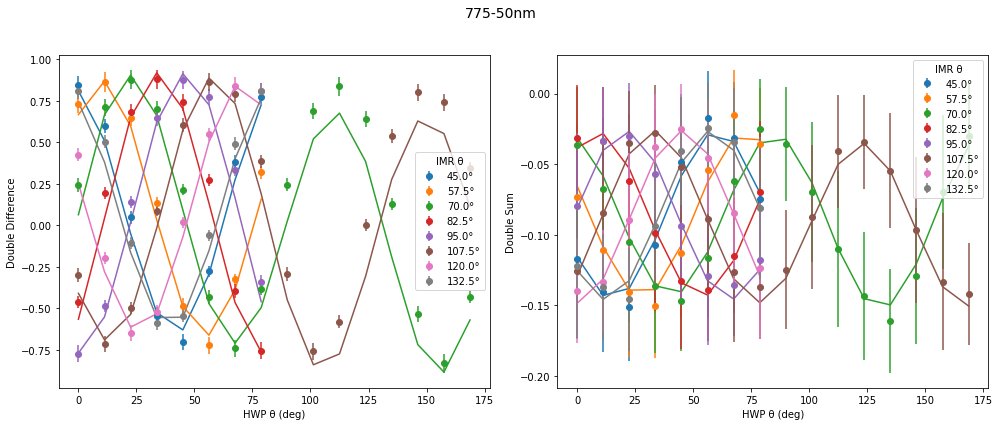

Before p0: {'dichroic': {'phi': 1.3764243819248705, 'epsilon': 0.002704207405255751, 'theta': 7.254640119333228}, 'flc': {'phi': 2.632458460684317, 'delta_theta': 4.395796688939583}, 'optics': {'phi': 0.6411787275576513, 'epsilon': 1.1176067851459513e-07, 'theta': -17.116911324181473}, 'image_rotator': {'phi': 3.165689224407034}, 'hwp': {'phi': 2.8950593774410223, 'delta_theta': 4.965787403276952}, 'lp': {'theta': 1.1294517466411973}}
Iteration #: 1
logl_value: 358.3201591303312
Best Fit Parameters: [ 1.84930206e+00  3.01805857e-03  6.84257446e+00  2.64282507e+00
  4.32969989e+00  4.74461621e-01  8.31475820e-06 -2.60674706e+01
  3.16602664e+00  2.89527124e+00  4.99467689e+00  1.21648768e+00]


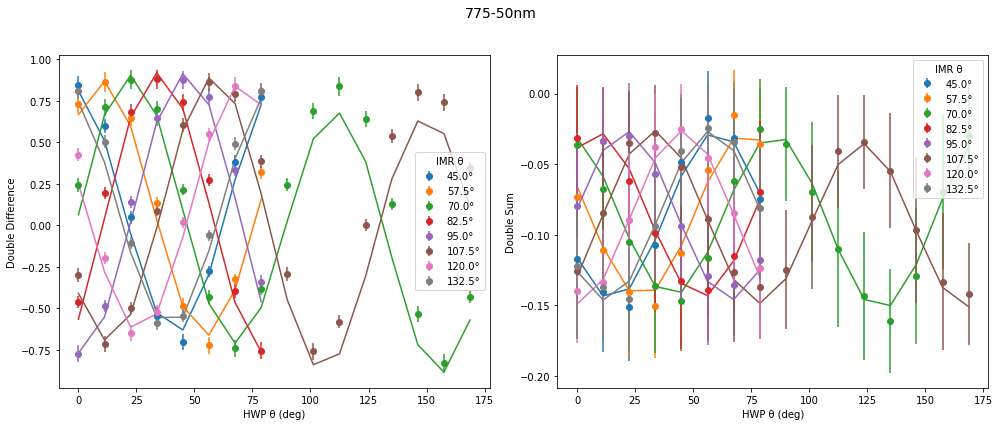

After p0: {'dichroic': {'phi': 1.8493020564478124, 'epsilon': 0.0030180585715444278, 'theta': 6.84257445789741}, 'flc': {'phi': 2.64282506654123, 'delta_theta': 4.3296998922438945}, 'optics': {'phi': 0.4744616209266271, 'epsilon': 8.31475820114885e-06, 'theta': -26.06747063563426}, 'image_rotator': {'phi': 3.1660266425608925}, 'hwp': {'phi': 2.8952712433599466, 'delta_theta': 4.9946768870715825}, 'lp': {'theta': 1.2164876815396992}}
Before p0: {'dichroic': {'phi': 1.8493020564478124, 'epsilon': 0.0030180585715444278, 'theta': 6.84257445789741}, 'flc': {'phi': 2.64282506654123, 'delta_theta': 4.3296998922438945}, 'optics': {'phi': 0.4744616209266271, 'epsilon': 8.31475820114885e-06, 'theta': -26.06747063563426}, 'image_rotator': {'phi': 3.1660266425608925}, 'hwp': {'phi': 2.8952712433599466, 'delta_theta': 4.9946768870715825}, 'lp': {'theta': 1.2164876815396992}}
Iteration #: 2
logl_value: 358.30499163699517
Best Fit Parameters: [ 1.65569318e+00  2.96459098e-03  6.74222187e+00  2.646958

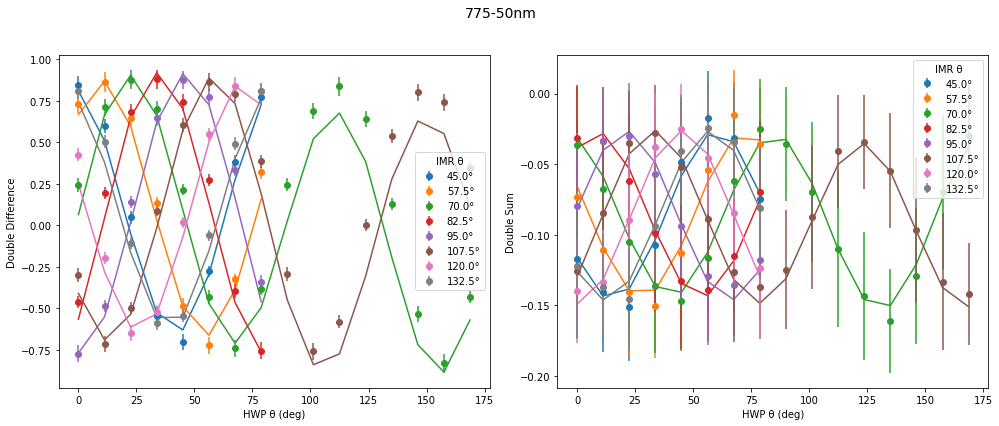

After p0: {'dichroic': {'phi': 1.6556931803204185, 'epsilon': 0.0029645909829048994, 'theta': 6.742221869326222}, 'flc': {'phi': 2.646958050243832, 'delta_theta': 3.2653027780837593}, 'optics': {'phi': 0.453445958219024, 'epsilon': 2.1355349866034125e-06, 'theta': -28.825721485081473}, 'image_rotator': {'phi': 3.165963388097847}, 'hwp': {'phi': 2.895227417125117, 'delta_theta': 4.999779869018546}, 'lp': {'theta': 1.1924330835013137}}


In [3]:
# Defining wavelength
for i, wavelength in enumerate(wavelengths):
    interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
        obs_mode = obs_modes[i], obs_filter = wavelength)

    filename = "/home/rebeccaz/Github/vampires_calibration/scipy_minimize/data_files/produced/775-50nm_no_IMR_offset_or_IMR_and_HWP_constraints.txt"

    # Using closest broadband files    
    with open(filename, "r") as f:
        past_fit = json.load(f)
    print(past_fit)

    theta_pol = past_fit["lp"]["theta"]
    delta_HWP = past_fit["hwp"]["phi"] 
    offset_HWP = past_fit["hwp"]["delta_theta"]
    delta_derot = past_fit["image_rotator"]["phi"] 
    delta_opts = past_fit["optics"]["phi"]
    epsilon_opts = past_fit["optics"]["epsilon"]
    rot_opts = past_fit["optics"]["theta"]
    delta_dichroic = past_fit["dichroic"]["phi"]
    epsilon_dichroic = past_fit["dichroic"]["epsilon"]
    rot_dichroic = past_fit["dichroic"]["theta"]
    delta_FLC = past_fit["flc"]["phi"] 
    rot_FLC = past_fit["flc"]["delta_theta"]
    em_gain = em_gains[i] # from EM gain measurements

    # NOTE: Components must be listed downstream to upstream
    # Define the instrument configuration as a system dictionary
    system_dict = {
        "components": {
            "wollaston": {
                "type": "wollaston_prism_function",
                "properties": {"beam": "o", "transmission_ratio": em_gain},
            },
            "dichroic": {
                "type": "diattenuator_retarder_function",
                "properties": {'phi': delta_dichroic, 
                    'epsilon': epsilon_dichroic, 'theta': rot_dichroic},
            },
            "flc": {
                "type": "general_retarder_function",
                "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
            },
            "optics": {
                "type": "diattenuator_retarder_function",
                "properties": {'phi': 2 * np.pi * delta_opts, 
                    'epsilon': epsilon_opts, 'theta': rot_opts},
            },
            "image_rotator": {
                "type": "general_retarder_function",
                "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": 0},
            },
            "hwp": {
                "type": "general_retarder_function",
                "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
            },
            "lp": {
                "type": "general_linear_polarizer_function_with_theta",
                "properties": {"theta": theta_pol},
            },
        }
    }

    # Setting bounds
    bounds = [ 
    (0, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    (0.25 * 2 * np.pi, 0.75 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (0, 2 * np.pi),  # delta_opts
    (0, 1),  # epsilon_opts
    (-90, 90),  # rot_opts
    (0, 2 * np.pi),  # delta_derot
    (0, 2 * np.pi),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5),  # theta_pol
]

    # Turn dictionary into matrix
    system_mm = inst.generate_system_mueller_matrix(system_dict)
    print(system_mm.evaluate())

    # Set-up for p0
    p0 = {
    # "wollaston": {"transmission_ratio": em_gain}, 
    "dichroic": {"phi": np.abs(delta_dichroic), 
                 "epsilon": epsilon_dichroic, 
                 "theta": rot_dichroic},
    "flc": {"phi": delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": np.abs(delta_opts), "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {
                    "phi": delta_derot, 
                    # "delta_theta": 0
                    },
    "hwp": {"phi": delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
    }

    # Adding p0
    p0_values, p0_keywords = inst.parse_configuration(p0)
    s_in = np.array([1, 0, 0, 0])
    logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
        s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
        process_model=inst.process_model)
    print("logl value: " + str(logl_value))

    # Plotting intial plot
    updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
    model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
        process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength)

    # Iterative Fitting
    # Unpolarized light for s_in as there is LP in the system already
    s_in = np.array([1, 0, 0, 0])

    # Counters for iterative fitting
    iteration = 1
    previous_logl_value = 1000000
    new_logl_value = 0

    while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
        print("Before p0: " + str(p0))
        if iteration > 1: 
            previous_logl_value = new_logl_value
        result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
            interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
            process_dataset = inst.process_dataset, 
            process_errors = inst.process_errors, 
            process_model = inst.process_model, bounds = bounds)
        
        # Print statements
        print("Iteration #: " + str(iteration))
        print("logl_value: " + str(new_logl_value))
        print("Best Fit Parameters: " + str(result.x))

        # Making a plot
        updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
        model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
        process_model = inst.process_model)

        save_path = save_fits_directory + str(wavelength) + "nm_no_IMR_offset_with_IMR_and_HWP_upper_bounds_no_FLC_constraints.png"
        inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
            configuration_list, wavelength = wavelength, save_path = save_path)

        # Updating p0 for next time
        inst.update_p0(p0, result.x)
        print("After p0: " + str(p0))

        iteration += 1

        filename = save_fits_directory + str(wavelength) + "nm_no_IMR_offset_with_IMR_and_HWP_upper_bounds_no_FLC_constraints.txt"
        with open(filename, 'w') as f:
            json.dump(p0, f, indent=4)